# Support Vector Machine

### 1 &ensp; Setup

In [1]:
import itertools
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix

import qpsolvers as qps

### 2 &ensp; Primal & Dual programs

##### Plot functions

In [2]:
plt.rcParams["figure.figsize"] = [15, 10]

def plot_data(X, y, colors=['blue', 'red']):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=ListedColormap(colors))

def plot_classifier(w, X, y, title):

    # Calc boundaries
    x_min = np.amin(X[:, 0])
    x_max = np.amax(X[:, 0])
    y_min = np.amin(X[:, 1])
    y_max = np.amax(X[:, 1])
    
    # Generate grid
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    
    xx, yy = np.meshgrid(xx, yy)
    xy = np.c_[xx.ravel(), yy.ravel()] 

    z = np.c_[xy, np.ones(xy.shape[0])] @ w
    z = z.reshape(xx.shape)
    
    # Plot
    plt.title(title)
    plt.contour(xx, yy, z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--','-', '--'])

def highlight_support_vectors(X, alpha, th):
    sv = np.argwhere(np.abs(alpha) > th).reshape(-1)
    plt.scatter(X[sv,0], X[sv,1], s=150, linewidth=2, facecolors='none', edgecolors='k')

##### Load the dataset

In [3]:
# Load
data = pd.read_csv('simple_classification.csv')
X, y = data.drop(columns=['y']), data['y']

# Add bias, correct labels
X = np.c_[X.to_numpy(), np.ones(len(X))]
y = y.transform(lambda x: x if x else -1).to_numpy()

##### SVM Primal Program

In [4]:
def svm_primal(X, y):
    N, n = X.shape

    # Objective
    P = np.eye(n)
    q = np.zeros(n)
    
    # Constraints
    G = -np.diag(y) @ X
    h = -np.ones(N)

    # Solution
    w = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver="osqp")
    print(f"SVM Primal solution is: {w}")

    return w

SVM Primal solution is: [ 1.19553571  0.34700045 -6.52243901]


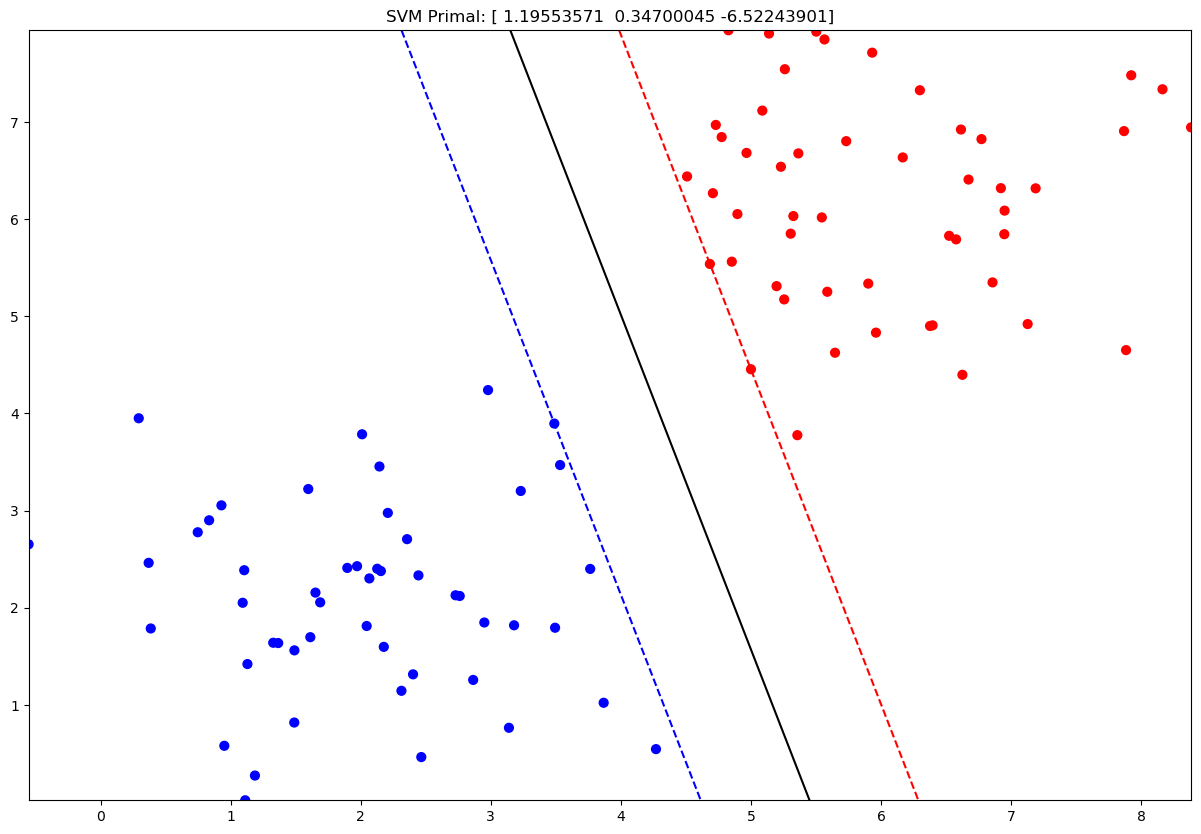

In [5]:
# solve using primal
w = svm_primal(X, y)

# Plot svm solution
plot_data(X, y)
plot_classifier(w, X, y, f"SVM Primal: {w}")

##### SVM Dual Program

In [6]:
def svm_dual(X, y):
    N = X.shape[0]

    # Objective
    GG = np.diag(y) @ X
    P = GG @ GG.T
    q = -np.ones(N)

    # Constraints
    G = -np.eye(N)
    h = np.zeros(N)

    # Solution
    alpha = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp')
    w = GG.T @ alpha
    print(f"SVM Dual solution is: {w}")
    
    return alpha, w


SVM Dual solution is: [ 1.185658    0.35641661 -6.52274395]


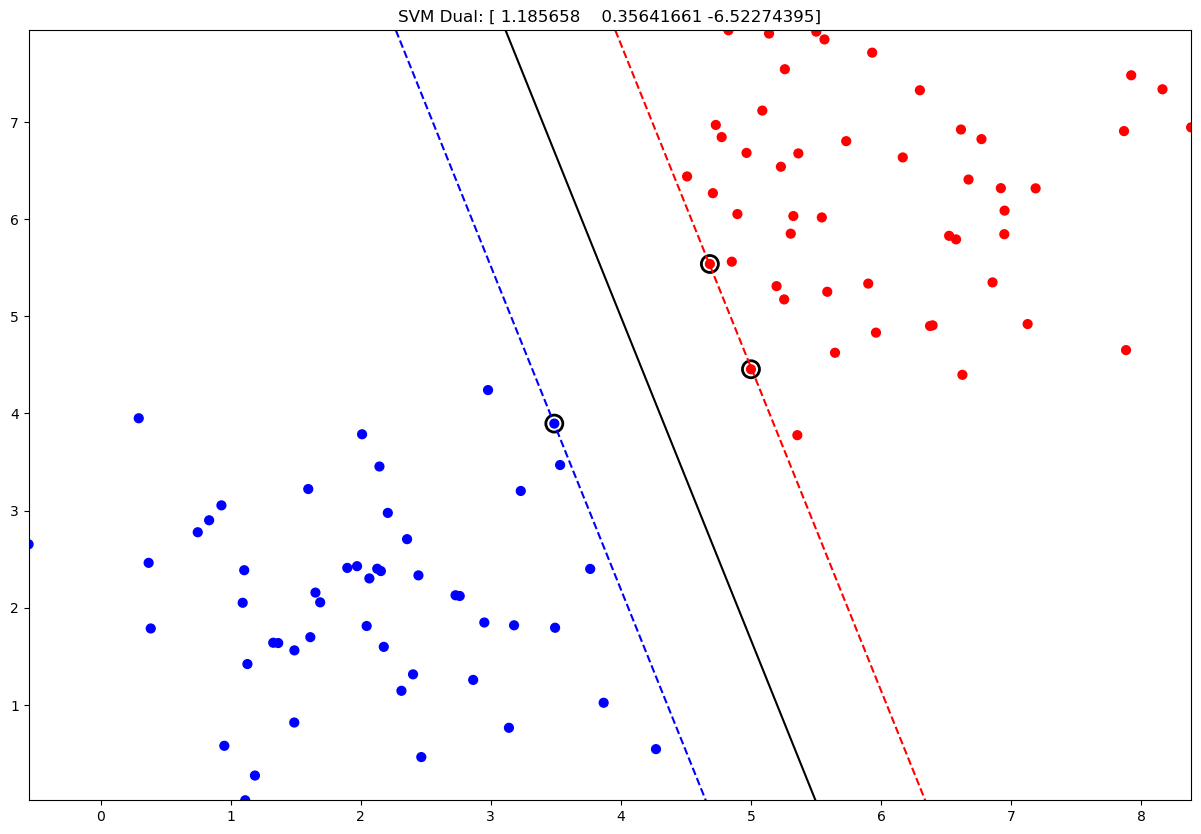

In [7]:
# solve using primal
a, w = svm_dual(X, y)

# Plot svm solution
plot_data(X, y)
plot_classifier(w, X, y, f"SVM Dual: {w}")
highlight_support_vectors(X, a, th=0.1)

### 3 &ensp; Kernels

Split function

In [8]:
def my_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

Plot function

In [9]:
def plot_classifier_with_kernel(alpha, X, y, kernel, title, colors):

    # Calc boundries
    x_min = np.amin(X[:, 0])
    x_max = np.amax(X[:, 0])
    y_min = np.amin(X[:, 1])
    y_max = np.amax(X[:, 1])
    
    # Build grid
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    
    xx, yy = np.meshgrid(xx, yy)
    
    # Build countour using kernel
    N = X.shape[0]
    z = np.zeros(xx.shape)
    for i, j in itertools.product(range(xx.shape[0]), range(xx.shape[1])):
        z[i, j] = sum([
            y[k] * alpha[k] * kernel(X[k, :], np.array([xx[i, j], yy[i, j]])) 
            for k in range(N)
        ])

    # Plot            
    plt.title(title)
    plt.contour(xx, yy, z, levels=[-1, 0, 1], colors=colors, linestyles=['--','-', '--'])

SVM Dual Program with Kernel

In [10]:
def svm_dual_kernel(X, y, k):

    # Objective, using kernel
    N = X.shape[0]
    P = np.empty((N, N))
    for i, j in itertools.product(range(N), range(N)):
        P[i, j] = y[i] * y[j] * k(X[i, :], X[j, :])
    q = -np.ones(N)

    # Constraints
    G = -np.eye(N)
    h = np.zeros(N)

    # Solution
    alpha = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp', max_iter=4000, verbose=False)
    
    return alpha

Evaluating solution

In [11]:
def svm_score(alpha, X_train, y_train, k, X_score, y_score):
    predictions = np.zeros_like(y_score)

    # Evaluate wT @ x
    for i, x in enumerate(X_score):
        predictions[i] = np.sum([alpha[_i] * y_train[_i] * k(_x, x) for _i, _x in enumerate(X_train)])

    return (np.sign(predictions) == y_score).sum() / len(y_score)

Non-linear classification

In [12]:
def simple_nonlin_classification(kernel, k_name="", sv_th=0.01, plot=False):
    # Load data
    data = pd.read_csv('simple_nonlin_classification.csv')
    X, y = data.drop(columns=['y']).to_numpy(), data['y'].transform(lambda x: x if x else -1).to_numpy()

    # Split the data
    X_train, X_test, y_train, y_test = my_train_test_split(X, y)

    # Solve
    a = svm_dual_kernel(X_train, y_train, kernel)

    # predict & evaluate
    score = svm_score(a, X_train, y_train, kernel, X_test, y_test)

    if plot:
        # Plot train data
        plot_data(X_train, y_train)
        plot_classifier_with_kernel(a, X_train, y_train, kernel, k_name, colors=['blue', 'black', 'red'])
        highlight_support_vectors(X_train, a, sv_th)

        # Plot test data
        plot_data(X_test, y_test, colors=['green', 'pink'])

    return score

Defining different kernels

In [13]:
def poly_kernel(degree, gamma):
    return lambda x, y: (gamma * x.T @ y + 1) ** degree, f"Poly (degree = {degree}, gamma = {gamma})"

def rbf_kernel(gamma):
    return lambda x, y: np.exp(-gamma * (x - y).T @ (x - y)), f"RBF (gamma = {gamma})"

Conducting some experiments

In [14]:
# Hyperparameter spaces
degrees_poly = np.linspace(2, 10, 5)
gammas_poly = np.round(np.geomspace(0.1, 30, 5), 3)
results_poly = np.zeros((len(degrees_poly), len(gammas_poly)))

# Experiments
for d, deg in enumerate(degrees_poly):
    for g, gam in enumerate(gammas_poly):
        kernel, name = poly_kernel(degree=deg, gamma=gam)
        results_poly[d, g] = simple_nonlin_classification(kernel)

Text(0.5, 1.0, 'Polynomial Kernel')

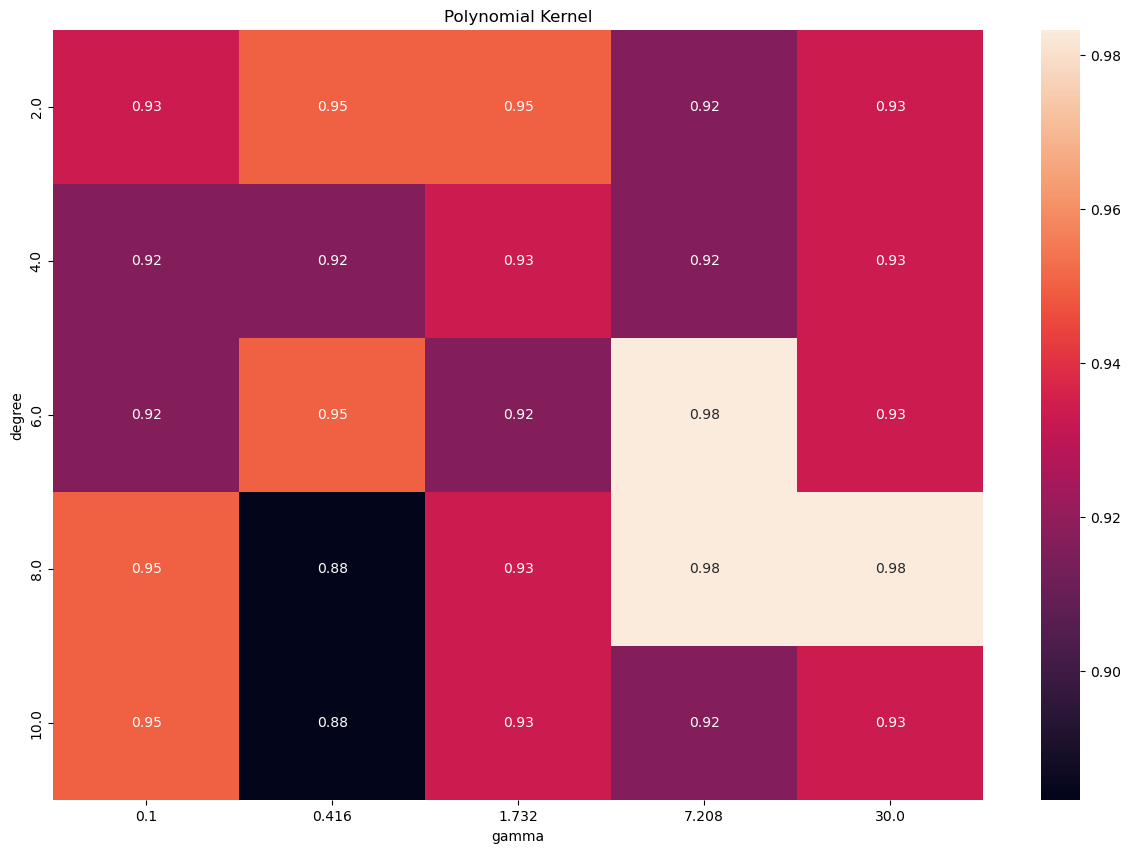

In [15]:
sns.heatmap(results_poly, annot=results_poly, xticklabels=gammas_poly, yticklabels=degrees_poly)
plt.xlabel("gamma")
plt.ylabel("degree")
plt.title("Polynomial Kernel")

In [16]:
# Hyperparameter spaces
gammas_rbf = np.round(np.geomspace(0.1, 30, 20), 3)
results_rbf = np.zeros(len(gammas_rbf))

# Experiments
for g, gam in enumerate(gammas_rbf):
    kernel, name = rbf_kernel(gamma=gam)
    results_rbf[g] = simple_nonlin_classification(kernel)

In [17]:
print("\t\t\tRBF Kernel Scores")
for i, (g, r) in enumerate(zip(gammas_rbf, results_rbf)):
    bar = "=" * ((int)(100 * r))
    print(f"{i+1}:\t{g= }   \t{bar} {r*100:.1f}%")

			RBF Kernel Scores
1:	g= 0.1   	=========================================================================================== 91.7%
2:	g= 0.135   	=========================================================================================== 91.7%
3:	g= 0.182   	=========================================================================================== 91.7%
4:	g= 0.246   	============================================================================================= 93.3%
5:	g= 0.332   	=============================================================================================== 95.0%
6:	g= 0.449   	=============================================================================================== 95.0%
7:	g= 0.606   	=============================================================================================== 95.0%
8:	g= 0.818   	============================================================================================= 93.3%
9:	g= 1.104   	==============================================

### 4 &ensp; Implementing SVC

SVM Classifier class

In [18]:
class SVMClassifier():
    def __init__(self, kernel='rbf', degree=3, C=1.0, gamma='scale'):
        
        # Store inputs
        self.k = kernel
        self.d = degree
        self.C = C
        self.g = gamma

    def __gamma(self):
        if self.g == 'scale':
            return 1 / (self.__X.shape[1] * self.__X.var())
        elif self.g == 'auto':
            return 1 / self.__X.shape[1]
        else:
            return self.g

    def __apply_kernel(self):

        # Kernel selection
        gamma = self.__gamma()
        self.kernel = {
            'linear': lambda x, y: x.T @ y,
            'poly': lambda x, y: (gamma * x.T @ y) ** self.d,
            'rbf': lambda x, y: np.exp(-gamma * (x - y).T @ (x - y)),
            'sigmoid': lambda x, y: np.tanh(gamma * x.T @ y)
        }[self.k]

        # Kernel operation
        N = self.__X.shape[0]
        return np.array([
            [
                self.__y[i] * self.__y[j] * self.kernel(self.__X[i, :], self.__X[j, :]) 
                for i in range(N)
            ]
            for j in range(N)
        ])

    def fit(self, X, y):

        # Store X for predicitons
        self.__X = np.copy(X)
        self.__y = np.copy(y)
        N = X.shape[0]
        
        # Objective, using kernel
        P = self.__apply_kernel()
        q = -np.ones(N)

        # Constraints
        G = np.block([[-np.eye(N)], [np.eye(N)]])
        h = np.block([np.zeros(N), self.C * np.ones(N)])

        # Solution
        self.__alpha = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp')

        return self

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def decision_function(self, X):
        decisions = np.zeros(X.shape[0])

        # Evaluate wT @ x
        for i, x in enumerate(X):
            decisions[i] = np.sum([self.__alpha[_i] * self.__y[_i] * self.kernel(_x, x) for _i, _x in enumerate(self.__X)])

        return decisions

    def score(self, X, y):
        return (self.predict(X) == np.array(y)).sum() / len(y)

### 5 &ensp; Breast Cancer Prediction

Loading the dataset

In [19]:
# Load data
data = pd.read_csv('Processed Wisconsin Diagnostic Breast Cancer.csv')
X, y = data.drop(columns=['diagnosis']).to_numpy(), data['diagnosis'].transform(lambda x: x if x else -1).to_numpy()

# Split the data
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

Conducting some experiments with random hyperparameters

In [20]:
# Hyperparameter spaces
num_experiments = 20
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = np.arange(2, 11)
gammas = np.round(np.geomspace(0.1, 30), 3)
Cs = np.round(np.geomspace(0.1, 5), 3)

# Experiments
random.seed(42)
experiments = random.sample(list(itertools.product(kernels, degrees, gammas, Cs)), num_experiments)
results_svc = []

# Experiments
for k, d, g, c in experiments:
        results_svc.append(SVMClassifier(kernel=k, degree=d, gamma=g, C=c).fit(X_train, y_train).score(X_test, y_test))

In [22]:
print("\t\t\t\t\t\t\t\t\tSVC Experiment Scores")
for i, ((k, d, g, c), r) in enumerate(zip(experiments, results_svc)):
    bar = "=" * ((int)(100 * r))
    print(f"{i+1}:\t{k=},\t{d=},\t\t{g=:.3f},\t{c=:.3f}\t\t{bar} {r*100:.1f}%")

									SVC Experiment Scores
1:	k='sigmoid',	d=8,		g=2.062,	c=0.222		============================================================== 62.3%
2:	k='linear',	d=7,		g=11.822,	c=2.859		=============================================================================================== 95.6%
3:	k='linear',	d=3,		g=0.573,	c=0.935		=============================================================================================== 95.6%
4:	k='poly',	d=7,		g=1.026,	c=4.616		============================================================================================= 93.9%
5:	k='poly',	d=5,		g=11.822,	c=4.616		=========================================================================================== 91.2%
6:	k='poly',	d=4,		g=5.880,	c=0.161		============================================================================================== 94.7%
7:	k='linear',	d=9,		g=0.573,	c=2.250		=============================================================================================== 95.6%
8:	k='linear',	d=7,		g=0.